### Imports

In [74]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
from keras import Sequential
from keras.applications import vgg16
from keras.layers import Dense, Flatten
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import adam_v2

# % matplotlib inline


### Constants

In [75]:
# Get train and test data from folder.
TRAIN_DIRECTORY = Path("data/AFD/AFD（Animal Face Dataset)/face images/Saimiri sciureus")

# Image Specifications
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3
IMAGE_DIMENSIONS = (IMG_HEIGHT, IMG_WIDTH)

# Cross Fold Validation
TEST_SIZE = 0.1  # 10% reserved for testing
NUMBER_FOLDS = 10  # 10 fold CV
NUMBER_REPEATS = 1  # number of times to repeat k-fold cv

# MODEL PARAMETERS
BATCH_SIZE = 32  # This is keras default
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

# Seed - for reproducibility
SEED = 123

### Load Data

In [76]:
def load_image_dataset(directory, img_width, img_height: (np.ndarray, np.ndarray)):
    X = []
    y = []

    for root, _, files in os.walk(directory):
        if not files:
            continue

        root = Path(root)
        dir_name = root.name

        for file in files:
            file_path = root / file
            assert file_path.is_file()

            img = plt.imread(str(file_path))
            if img is not None:
                # Add to the dataset
                res = cv2.resize(img, dsize=(img_width, img_height))
                X.append(res)
                y.append(int(dir_name))
            else:
                # indicate image was skipped
                print("Unable to read file '{}' Skipping".format(str(file_path.absolute())))

    print(len(X))
    print("First image")
    plt.imshow(X[1])

    # Convert to batch along the 0th axis
    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)

    return X, y

504
First image
(array([ 5,  6,  8,  9, 10, 12, 18, 19, 20, 22, 24, 27, 28, 31, 32, 33, 34,
       35, 41, 42, 43], dtype=int64),)


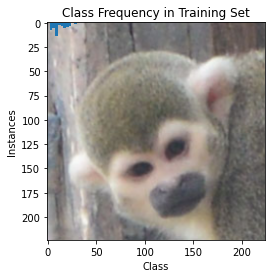

In [77]:
X, y = load_image_dataset(TRAIN_DIRECTORY, img_width=IMG_WIDTH, img_height=IMG_HEIGHT)

# Convert to batch along the 0th axis
X = np.stack(X, axis=0)
y = np.stack(y, axis=0)

classes, counts = np.unique(y, return_counts=True)

# TODO - add 1 for false-positives (not a monkey), 1 for previously unseen individuals
number_classes = len(classes)

too_few = np.nonzero(np.where(counts < NUMBER_FOLDS, classes, 0))
print(too_few)

plt.hist(counts)
plt.ylabel("Instances")
plt.xlabel("Class")
plt.title("Class Frequency in Training Set")
plt.show()

In [78]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,
                                                                            y,
                                                                            shuffle=True,
                                                                            test_size=TEST_SIZE,
                                                                            random_state=SEED,
                                                                            stratify=y
                                                                            )

print("Train size: ", len(X_train))
print("Test size: ", len(X_test))

Train size:  453
Test size:  51


### Model Architecture

In [79]:
class VGGModel:
    def __init__(self, epochs):
        self.model = self.make_model()
        self.histogram = None
        self.epochs = epochs

    def make_model(self):
        # See here for implementation https://keras.io/api/applications/vgg/#vgg16-function
        vgg_model = vgg16.VGG16(
            include_top=False,
            weights="imagenet",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS),
            pooling='avg',  # Global average pooling applied.
        )
        # Freeze all layers
        vgg_model.trainable = False
        fully_connected_output = Sequential()

        # Add dense layers to perform prediction
        fully_connected_output.add(Flatten())
        fully_connected_output.add(Dense(units=4096, activation="relu"))
        fully_connected_output.add(Dense(units=4096, activation="relu"))
        fully_connected_output.add(Dense(units=number_classes, activation="softmax"))

        # Create final model
        return Sequential([vgg_model, fully_connected_output])

    def compile(self):
        optimizer = adam_v2.Adam(learning_rate=LEARNING_RATE)

        # sparse as Y values are stored as integers (0-42), rather than one-hot encoded (i.e. 3 class, [1,0,0], [0,1,0], [0,0,1])
        loss = sparse_categorical_crossentropy

        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Pre-Process Data for VGG
    @staticmethod
    def pre_process(X_unprocessed):
        # is performing in slices
        return np.apply_along_axis(func1d=lambda x: vgg16.preprocess_input(x), axis=0, arr=X_unprocessed)

    def fit(self, raw_X, raw_y):
        preprocessed_X = self.pre_process(raw_X)
        self.histogram = self.model.fit(
            x=preprocessed_X,
            y=raw_y,
            epochs=self.epochs,
            verbose=True)

    def evaluate(self, X_eval, y_eval):
        preprocessed_X = self.pre_process(X_eval)
        return self.model.evaluate(preprocessed_X, y_eval)

    def predict(self, X_pred):
        return self.model.predict(X_pred)

    def plot_results(self):
        self.plot_accuracy()
        self.plot_loss()

    def plot_accuracy(self):
        plt.plot(self.hist.history['accuracy'])
        plt.plot(self.hist.history['val_accuracy'])
        plt.title("Model Accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["training", "validation"])
        plt.show()

    def plot_loss(self):
        plt.plot(self.hist.history['loss'])
        plt.plot(self.hist.history['val_loss'])
        plt.title("Model Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["training", "validation"])
        plt.show()

In [80]:
repeated_stratified_k_fold = sklearn.model_selection.RepeatedStratifiedKFold(
    n_splits=NUMBER_FOLDS,
    n_repeats=NUMBER_REPEATS,
    random_state=SEED,
)

scores = np.zeros(shape=(repeated_stratified_k_fold.get_n_splits(X, y), 2))

for i, (train_index, test_index) in enumerate(repeated_stratified_k_fold.split(X, y)):
    print("*** Performing Repeat {}/{} Fold {}/{}***".format(round(i / NUMBER_FOLDS + 1) + 1,
                                                             NUMBER_REPEATS,
                                                             (i + 1) % (NUMBER_FOLDS + 1),
                                                             NUMBER_FOLDS), )
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = VGGModel(epochs=NUM_EPOCHS)
    model.compile()

    # Could split into batches here.
    print("Fitting Model:")
    model.fit(X_train, y_train)

    print()
    print("Evaluating Model")
    score = model.evaluate(X_test, y_test)
    scores[i, 0] = score[0]
    scores[i, 1] = score[1]

    print()
    print("Model Score")
    for j in range(len(model.model.metrics_names)):
        print("- {}: {:.2f}".format(model.model.metrics_names[j], score[j]))

    print("\n\n", end="")

*** Performing Repeat 2/1 Fold 1/10***


E:\Compsci 760 - Animal Indentification\python\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Fitting Model:
Epoch 1/20
15/15 [==============================] - 2s 102ms/step - loss: 13.8921 - accuracy: 0.1302

KeyboardInterrupt: 

In [ ]:
cross_validated_score = np.average(scores, axis=0)

print("Average Loss: {:.2f}".format(cross_validated_score[0]))
print("Average Accuracy: {:.2f}%".format(cross_validated_score[1]*100))
